## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy
import seaborn as sns
import pandas as pd
import csv
import os

## Files

In [3]:
# Modify as necessary
r2_dir = '../Results' # Where R2 results are stored

In [4]:
files = next(os.walk(r2_dir))[2]
files = [f for f in files if 'Br' in f]

## Organize Data

In [5]:
neural_regions = ['M1U', 'S1U', 'PFU', 'CSF']

raw_data = defaultdict(dict)
for f in files:
    dataset = f.split('.')[0]
    curr_file = pd.read_csv(r2_dir + '/' + f)

    column_names = list(curr_file.columns[1:])
    r2s = {cn : float(curr_file[cn].values) for cn in column_names}
    for nr in neural_regions:
        if nr in dataset:
            marker_region = dataset.split('_')[2]
            raw_data[nr][marker_region] = r2s

In [7]:
marker_regions = ['Anterior', 'Intermediate', 'Posterior', 'Superficial', 'Deep']
xyz = ['X', 'Y', 'Z']

def XYZ(markers):
    data = {
        'X': np.asarray([markers[i] for i in range(0, len(markers), 3)], dtype=float),
        'Y': np.asarray([markers[i + 1] for i in range(0, len(markers), 3)], dtype=float),
        'Z': np.asarray([markers[i + 2] for i in range(0, len(markers), 3)], dtype=float),
    }
    return data

xyz_data = defaultdict(dict)
for nr in neural_regions:
    for mr in marker_regions:
        values = list(raw_data[nr][mr].values())
        xyz_data[nr][mr] = XYZ(values)

## Heat Map

In [9]:
def get_frame(regions, features, data):
    feature = []
    region = []
    values = []
    for r in regions:
        for i in range(3):
            region.append(r)
        feature.append(features[0])
        feature.append(features[1])
        feature.append(features[2])
    for d in data:
        values.append(np.mean(d['X']))
        values.append(np.mean(d['Y']))
        values.append(np.mean(d['Z']))
    dict = {
        'Axis': feature,
        'Region': region,
        'Values': values
    }

    return pd.DataFrame(dict)

def heatmap(frame, title):
    heatmap = frame.pivot(columns='Axis',index='Region', values='Values')

    plt.figure(figsize=(6, 4))
    plt.suptitle(title)
    sns.heatmap(heatmap, vmin = 0, vmax = 1, annot=True, cmap='inferno')
    plt.show()

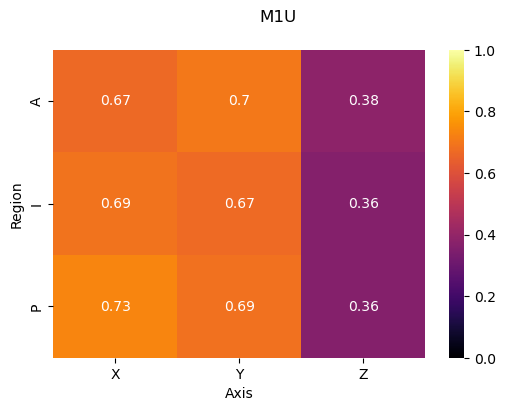

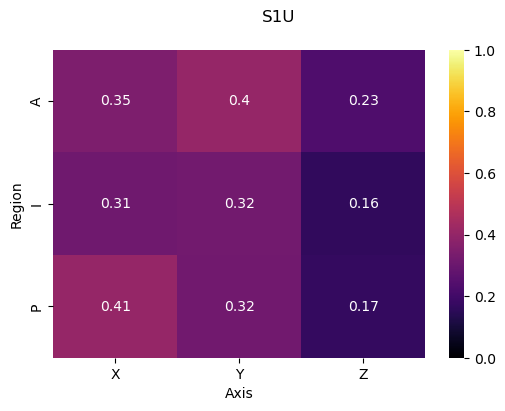

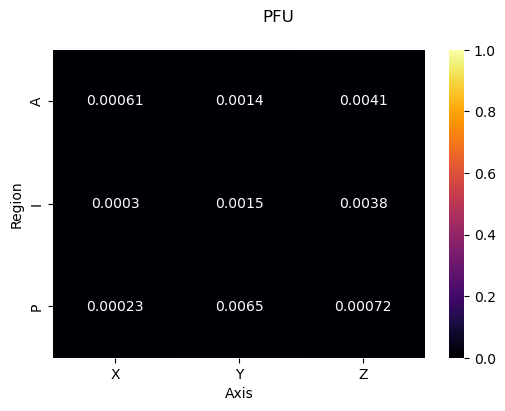

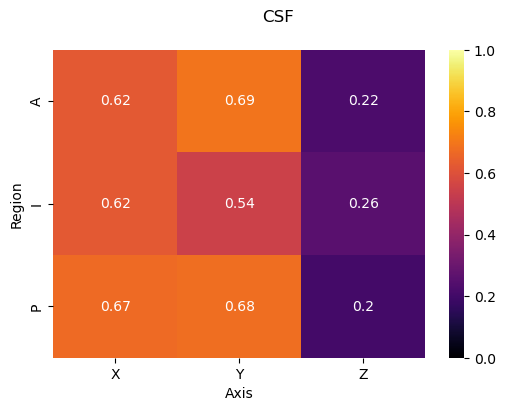

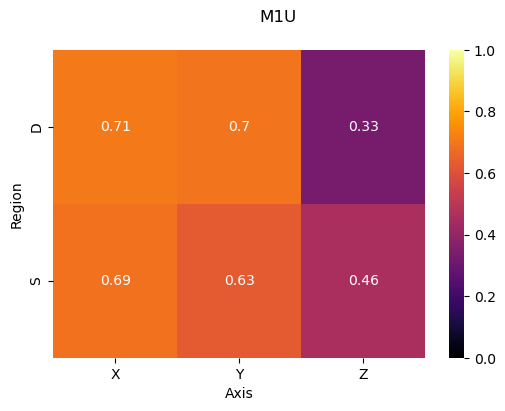

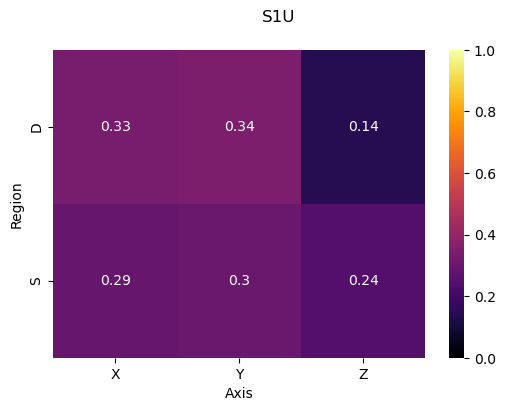

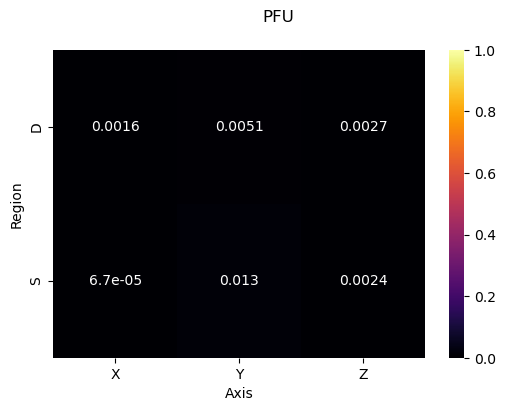

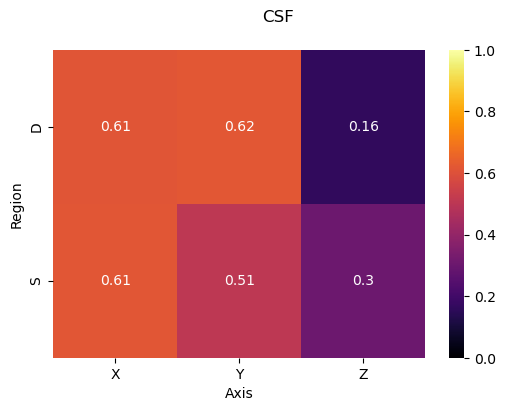

In [13]:
for nr in neural_regions:
    frame = get_frame(['A', 'I', 'P'], ['X', 'Y', 'Z'], [xyz_data[nr]['Anterior'], xyz_data[nr]['Intermediate'], xyz_data[nr]['Posterior']])
    heatmap(frame, nr)

for nr in neural_regions:
    frame = get_frame(['S', 'D'], ['X', 'Y', 'Z'], [xyz_data[nr]['Superficial'], xyz_data[nr]['Deep']])
    heatmap(frame, nr)

## Spike Histogram

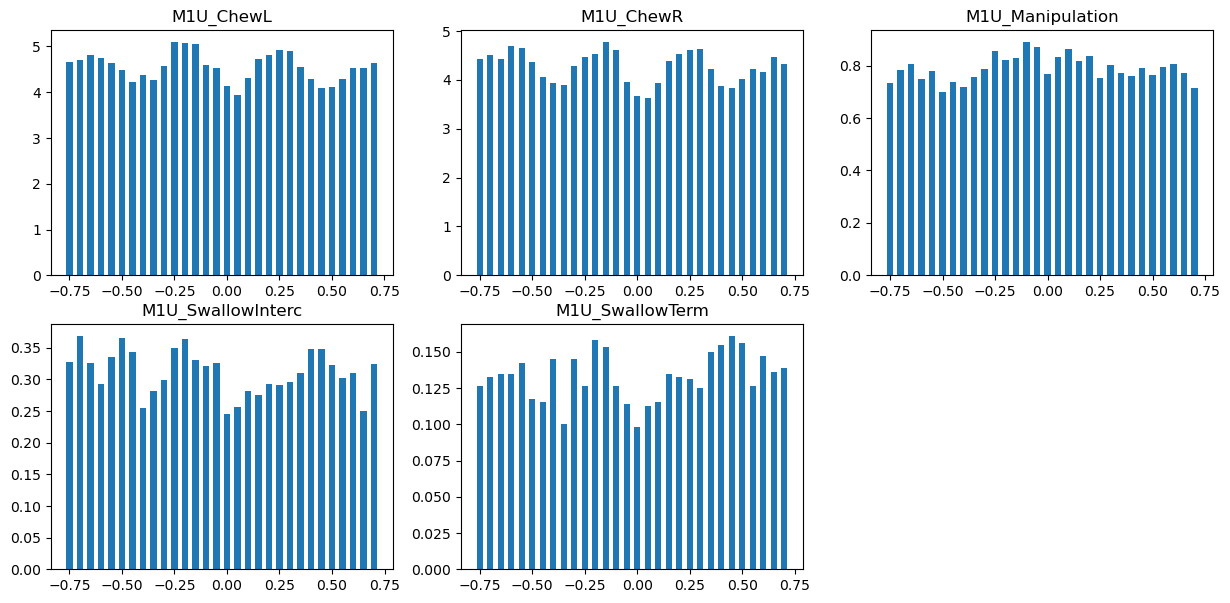

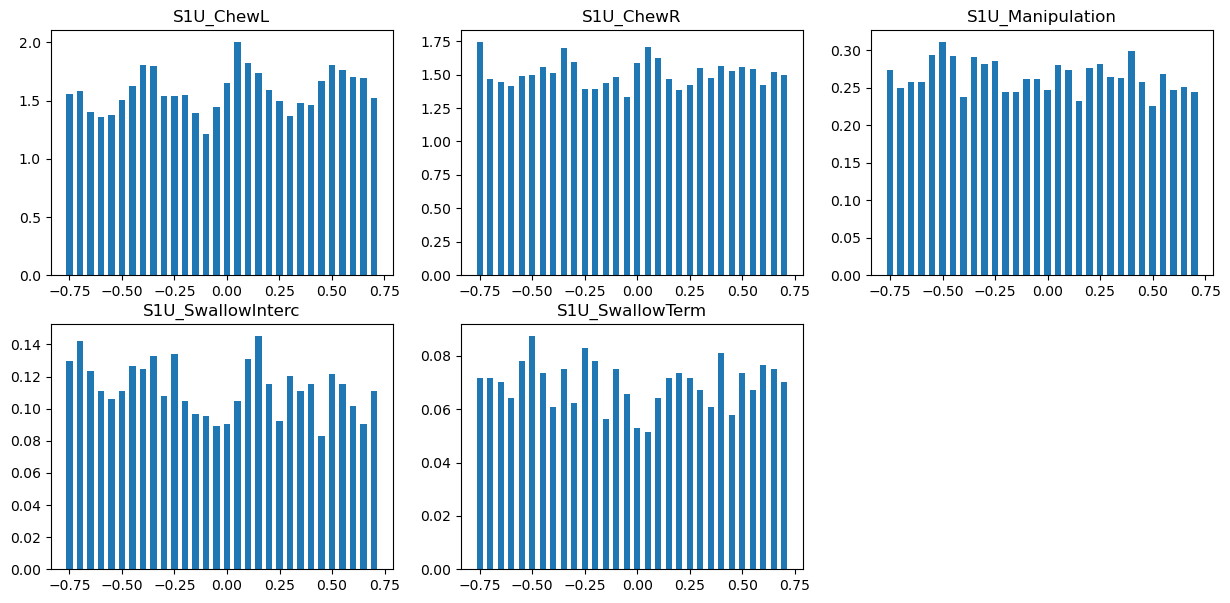

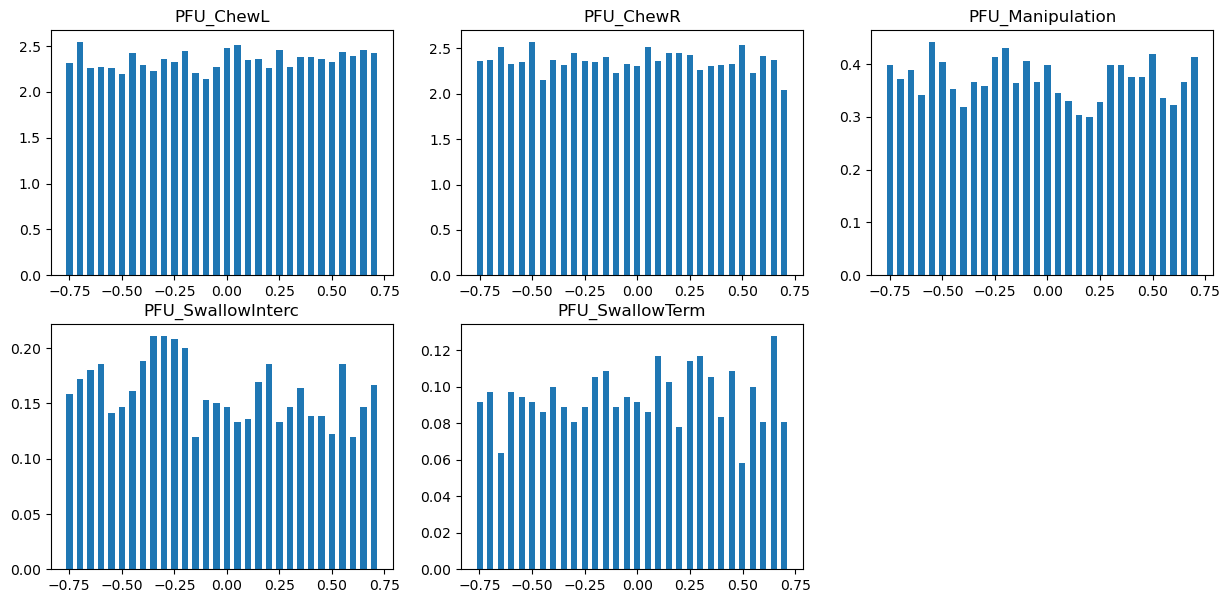

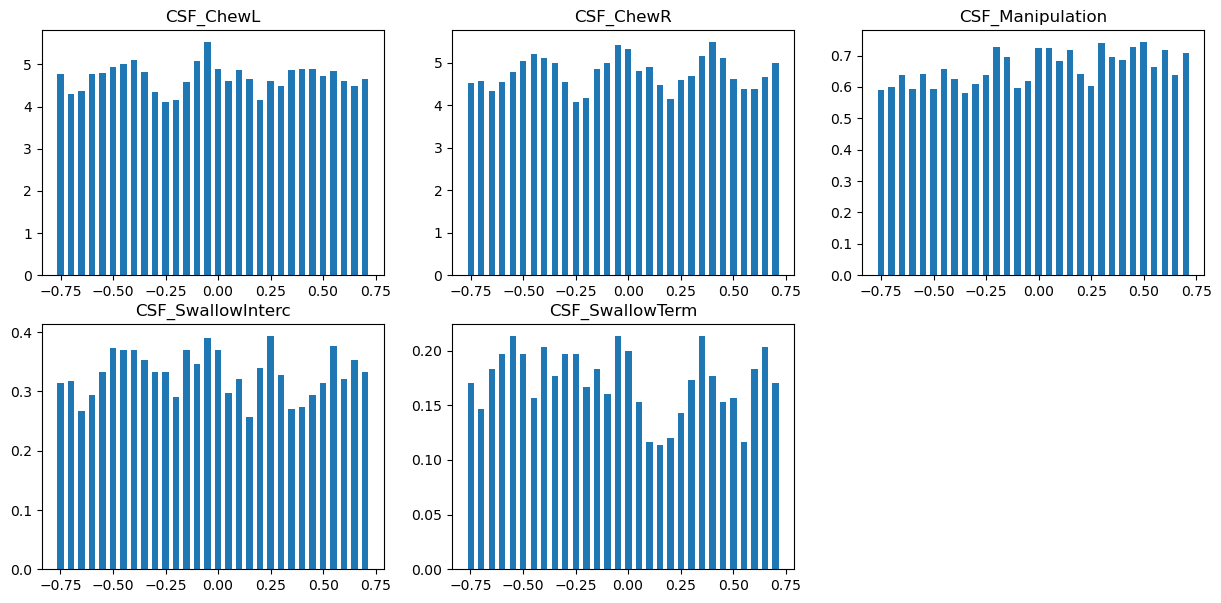

In [11]:
cycles = ["ChewL", "ChewR", "Manipulation", "SwallowInterc", "SwallowTerm"]
cycle_path = "../spikesByCycle/"

def test_cycle(data, cycle):
    if data["cycleType"] != cycle.lower():
        print("Expected: ", cycle)
        print("Real: ", data["cycleType"])
    return

for d_i, d in enumerate(neural_regions):
    plt.figure(figsize=(15, 7))
    for c_i, c in enumerate(cycles):
        cycle_data = scipy.io.loadmat(cycle_path + "Br_" + c)
        test_cycle(cycle_data, c)
        
        input = None
        neurons = list(cycle_data["spikesByGapeCycle"][d.lower()][0, 0].dtype.names)
        neurons.remove('cystart')
        neurons.remove('cyend')
        num_neurons = len(neurons)
        for i, neuron in enumerate(neurons):
            neuron_spikes = cycle_data["spikesByGapeCycle"][d.lower()][0, 0][neuron]
            for j in range(neuron_spikes.shape[1]):
                extracted = np.squeeze(neuron_spikes[0, j][0, 0][0], axis=1)
                input = extracted if i == 0 and j == 0 else np.concatenate((input, extracted))
        
        plt.subplot(2, 3, c_i + 1)
        plt.title(d + "_" + c)
        y, x = np.histogram(input, bins=30)
        plt.bar(x[:-1], y / (num_neurons * 20), width=0.03)
    plt.show()  